# Implementing ARIMA Model

***

In [1]:
# load modules
import pmdarima as pm
import statsmodels.tools.eval_measures as em
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import weekly finance series, skipping column names
ts = np.genfromtxt("../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

In [3]:
# store the total number of series and the number of time periods
num_series, num_t = ts.shape

***

## Model Implementation - One Series

#### 1. Plot the data

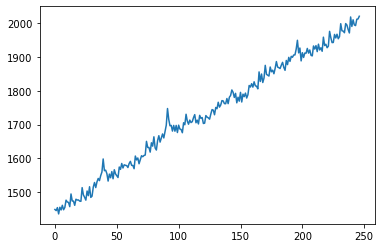

In [4]:
# plot a random series we will use for model testing
x = ts[100,:]
plt.plot(x)

Highly auto-correlated series.

c:\users\cameron\appdata\local\programs\python\python38\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


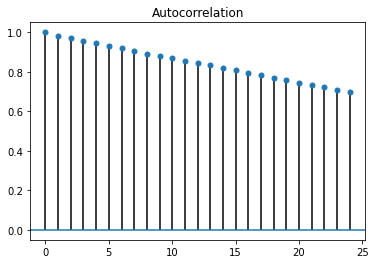

In [5]:
# autocorrelation plot
pm.plot_acf(x)

#### 2. Pre-processing for auto-ARIMA

The stepwise approach follows the strategy laid out by Hyndman and Khandakar in their 2008 paper, “Automatic Time Series Forecasting: The forecast Package for R”.

In [6]:
train, test = ts[100, :-20], ts[100, -20:]

#### 2.1. Conduct KPSS Test of Stationarity

[Seasonality blog post by Rob Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).

Doing this manually saves some computation time, [documentation here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html#pmdarima.arima.ndiffs). Used to pre-determine the number of differences to take `d`.

In [7]:
d = pm.arima.ndiffs(train, alpha = 0.05, test = 'kpss', max_d = 2)
d

1

#### 2.2. Conduct OCSB Test of Seasonality

Again, doing this manually saves some computation time, [documentation here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.OCSBTest.html#pmdarima.arima.OCSBTest.estimate_seasonal_differencing_term). Used to pre-determine the number of seasonal differences to take `D`.

In [8]:
# seasonal differencing term
# 52 weeks in a year, recommended by Hyndman
m = 52 
D = pm.arima.nsdiffs(train, m)
D

0

#### 3. Fit the Model

In [9]:
# fit stepwise auto-ARIMA
stepwise_fit = pm.auto_arima(train, 
                             m=52,                   # seasonal differencing term                
                             seasonal=True,          # compute seasonal model
                             d=d,                    # pre-calculated number of differences
                             D=D,                    # pre-calculated number of seasonal differences
                             trace=True,             # print optimization process results
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True, # don't want convergence warnings
                             stepwise=True)          # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=1734.536, Time=8.70 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1947.358, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1949.083, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=1732.487, Time=8.00 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=1861.166, Time=0.25 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=inf, Time=32.06 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=inf, Time=47.50 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=1732.161, Time=4.46 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=1867.751, Time=0.14 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=1733.873, Time=26.25 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=1733.878, Time=4.38 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AI

In [10]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  227
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -860.127
Date:                             Wed, 09 Feb 2022   AIC                           1728.254
Time:                                     20:07:31   BIC                           1741.936
Sample:                                          0   HQIC                          1733.776
                                             - 227                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5542      0.214      2.591      0.010       0.135       0.973
ma.L1         -0.5983      0.054    -10.998      0.000      -0.705      -0.492
ar.S.L52       0.7495      0.031     24.180      0.000       0.689       0.810
sigma2        97.7450      7.478     13.072      0.000      83.089     112.401
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                37.72
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.69
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 4. Check Residual Autocorrelation

c:\users\cameron\appdata\local\programs\python\python38\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


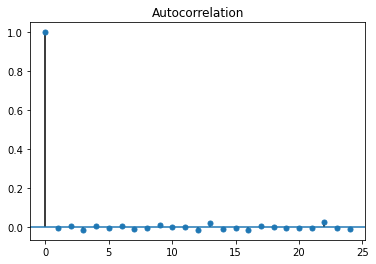

In [11]:
pm.plot_acf(stepwise_fit.resid())

#### 5. Make Predictions

In [12]:
prediction = stepwise_fit.predict(n_periods = 20)

#### 6. Evaluate Predictions

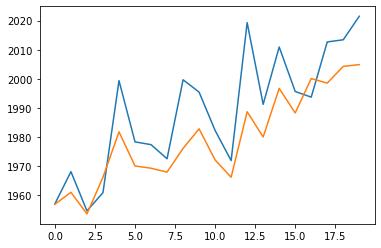

In [13]:
plt.plot(test, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.show()

In [14]:
em.rmse(test, prediction)

12.864228655335037

In [15]:
em.meanabs(test, prediction)

10.687242202643494

***

## Model Implementation - All Series

In [16]:
# 52 weeks in a year, recommended by Hyndman
m = 52

# forecast horizon
nfs = 20

# empty array to store forecasted values
pred_vals = np.zeros([num_series, nfs])
# empty array to store test values
test_vals = np.zeros([num_series, nfs])

In [ ]:
for i, series in enumerate(ts):
    
    if i % 1 == 0:
        print(i, 'out of', num_series, 'models trained.')
    
    # split into training and testing data
    train, test = series[:-nfs], series[-nfs:]
    
    # store test data
    test_vals[i,:] = test
    
    # calculate the number of differences
    d = pm.arima.ndiffs(train, alpha = 0.05, test = 'kpss', max_d = 2)
    
    # calculate the number of seasonal differences
    D = pm.arima.nsdiffs(train, m, max_D = 2, test = 'ocsb')
    
    # fit stepwise auto-ARIMA
    stepwise_fit = pm.auto_arima(train, 
                                 m=m,                    # seasonal differencing term                
                                 seasonal=True,          # compute seasonal model
                                 d=d,                    # pre-calculated number of differences
                                 D=D,                    # pre-calculated number of seasonal differences
                                 trace=False,            # don't print optimization process results
                                 error_action='ignore',  # don't want to know if an order does not work
                                 suppress_warnings=True, # don't want convergence warnings
                                 stepwise=True)          # set to stepwise
    
    # make predictions for 20 period horizon
    prediction = stepwise_fit.predict(n_periods = nfs)
    
    # store predictions
    pred_vals[i,:] = prediction

0 out of 164 models trained.
1 out of 164 models trained.
2 out of 164 models trained.
3 out of 164 models trained.
4 out of 164 models trained.
5 out of 164 models trained.
6 out of 164 models trained.
7 out of 164 models trained.
8 out of 164 models trained.
9 out of 164 models trained.
10 out of 164 models trained.
11 out of 164 models trained.
12 out of 164 models trained.
13 out of 164 models trained.
14 out of 164 models trained.
15 out of 164 models trained.
16 out of 164 models trained.
17 out of 164 models trained.
18 out of 164 models trained.
19 out of 164 models trained.
20 out of 164 models trained.
21 out of 164 models trained.
22 out of 164 models trained.
23 out of 164 models trained.
24 out of 164 models trained.
25 out of 164 models trained.
26 out of 164 models trained.
27 out of 164 models trained.
28 out of 164 models trained.
29 out of 164 models trained.
30 out of 164 models trained.
31 out of 164 models trained.
32 out of 164 models trained.
33 out of 164 models

In [ ]:
# calculate root mean squared error and mean absolute error
# for predictions from all series

# empty arrays for errors
rmse = np.zeros(num_series)
mae = np.zeros(num_series)

for i in range(num_series):
    rmse[i] = em.rmse(test_vals[i,:], pred_vals[i,:])
    mae[i] = em.meanabs(test_vals[i,:], pred_vals[i,:])

In [ ]:
# average root mean squared error across series
np.mean(rmse)

In [ ]:
# average mean absolute error across series
np.mean(mae)

In [ ]:
plt.plot(test_vals[10,:], label = "Actual")
plt.plot(pred_vals[10,:], label = "Predicted")
plt.legend()

In [ ]:
plt.plot(test_vals[50,:], label = "Actual")
plt.plot(pred_vals[50,:], label = "Predicted")
plt.legend()

In [ ]:
plt.plot(test_vals[150,:], label = "Actual")
plt.plot(pred_vals[150,:], label = "Predicted")
plt.legend()

In [ ]:
plt.plot(test_vals[160,:], label = "Actual")
plt.plot(pred_vals[160,:], label = "Predicted")
plt.legend()

In [ ]:
plt.plot(test_vals[163,:], label = "Actual")
plt.plot(pred_vals[163,:], label = "Predicted")
plt.legend()

***

Testing with BoxCox transformation.

In [ ]:
series = ts[150,:]

BC = pm.preprocessing.BoxCoxEndogTransformer()

series = BC.fit_transform(series)[0]

In [ ]:
# split into training and testing data
train, test = series[:-nfs], series[-nfs:]

In [ ]:
# calculate the number of differences
d = pm.arima.ndiffs(train, alpha = 0.05, test = 'kpss', max_d = 2)
    
# calculate the number of seasonal differences
D = pm.arima.nsdiffs(train, m, max_D = 2, test = 'ocsb')
    
# fit stepwise auto-ARIMA
stepwise_fit = pm.auto_arima(train, 
                             m=m,                    # seasonal differencing term                
                             seasonal=True,          # compute seasonal model
                             d=d,                    # pre-calculated number of differences
                             D=D,                    # pre-calculated number of seasonal differences
                             trace=True,            # don't print optimization process results
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True, # don't want convergence warnings
                             stepwise=True)          # set to stepwise
    
# make predictions for 20 period horizon
prediction = stepwise_fit.predict(n_periods = nfs)

In [ ]:
stepwise_fit.summary()

In [ ]:
plt.plot(series)

In [ ]:
pm.plot_acf(stepwise_fit.resid())

In [ ]:
plt.plot(test, label = "Actual")
plt.plot(prediction, label = "Predicted")
plt.legend()